## Sepsis population using K-Means

#### Kayode Ayankoya

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import ExtraTreesClassifier
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportions_chisquare

#%matplotlib notebook

In [23]:
#get raw data and identify the features

features = ['organ_failure', 'hepatic', 'hematologic', 'metabolic',
       'neurologic', 'infection','organ_dysfunction',
       'mech_vent', 'heartrate_min', 'heartrate_max',
       'heartrate_mean', 'sysbp_min', 'sysbp_max', 'sysbp_mean', 'diasbp_min',
       'diasbp_max', 'diasbp_mean', 'resprate_mean', 'resprate_min',
       'resprate_max', #'tempc_mean', 'tempc_min', 'tempc_max',
       #'weight',
       #'bicarbonate_min', 'bicarbonate_max', 
        'bilirubin_min',
       'bilirubin_max', 'creatinine_min', 'creatinine_max', 'chloride_min',
       'chloride_max', 'glucose_min', 'glucose_max', 'hematocrit_min',
       'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max', 
       'platelet_min', 'platelet_max', 'potassium_min',
       'potassium_max', 'sodium_min', 'sodium_max', 'ptt_min', 'ptt_max',
       'bun_min', 'bun_max', 'pt_min', 'pt_max', 'wbc_min', 'wbc_max',
       'vent_duration', 
       'age', 'gender', 'pao2fio2', 'mingcs',
       'urineoutput', 
       #'respiration1', 
        'coagulation1', 'live1',
       'cardiovascular1', 'cns1', 'renal1','sepsis','angus','sofa','los', 'expire_flag','subject_id']


df = pd.read_csv('SepsisDetails_UniqueSubj.csv', usecols=features)

In [24]:
#It was identified later in the analysis that this subject was an outlier
#So, it was decided that the record should be excluded

df = df[df['subject_id'] != 12017]

In [25]:
#Remove pediatrics and likely outliers based on ages 
df_ = df[((df['age'] < 200) & (df['age'] > 18)) ] 

df0 = df_.dropna()


#Create the features only dataset
df_ = df0.drop(columns=['sepsis', 'angus', 'sofa','los', 'expire_flag'])
df_1 = df_.reset_index(drop=True)
df1 = df_1.set_index('subject_id')

# create dataset for Labels only and set subject ID as index
dfL_ = df0.loc[:, ['sepsis', 'angus', 'sofa','subject_id']]
dfL_1 = dfL_.reset_index(drop=True)
dfL = dfL_1.set_index('subject_id')

#create dataset for Outcomes and set subject ID as index
dfout_ = df0.loc[:, ['los', 'expire_flag','subject_id']]
dfout_1 = dfout_.reset_index(drop=True)
dfout = dfout_1.set_index('subject_id')

# Exploratory Data Analysis
We have lost a part of the dataset to missing data, however we are still left with more that 3000 patients. It is now important to check the data in order to ensure that it is representative of the population and we do not have outlieres.

### Demographic Variables

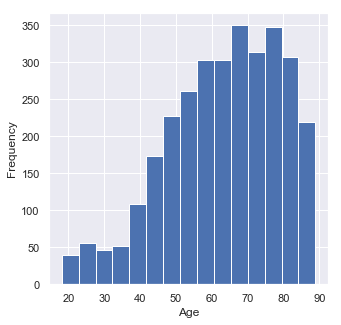

In [26]:
plt.figure(1, figsize=(5, 5))
plt.hist(df1.age, bins=15, density=False)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

This shows that the age distribution is still skewed to the right like the original data

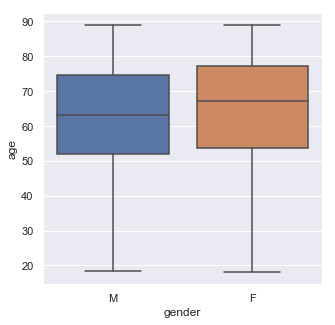

In [27]:
plt.figure(1, figsize=(5, 5))
sns.boxplot(x="gender", y="age",  data=df1)

The age distribution between male and female also appear to follow the same distribution and it seem like there is no significant different in the age distribution of male and female. The mean age is 64.45, median is 65.8 with a standard deviation of 15.80


## Vital Signs

Text(0.5, 1.0, 'Heart Rate')

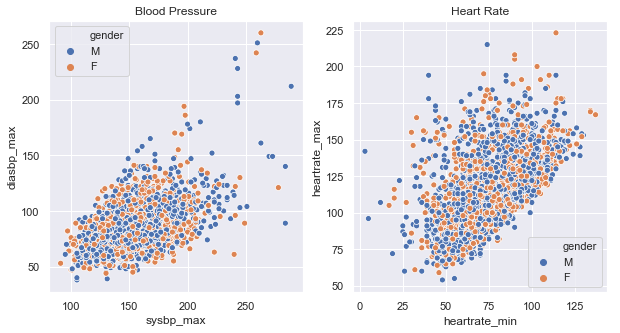

In [28]:
plt.rcParams["figure.figsize"] = (10,5)
fig, axs = plt.subplots(ncols=2)
sns.set(font_scale=1)

sns.scatterplot(x=df1.loc[:,'sysbp_max'], y=df1.loc[:,'diasbp_max'], hue=df1['gender'], ax = axs[0]).set_title('Blood Pressure')
sns.scatterplot(x=df1.loc[:,'heartrate_min'], y=df1.loc[:,'heartrate_max'], hue=df1['gender'], ax = axs[1]).set_title('Heart Rate')



An exploration of some of the demographic data and vital status above indicate that the data left is representative of the initial sepsis population and there are no obvious outliers

### K-Means Clustering Method
The range of variables in the data is quite different, therefore some transformation will be done using the StandardScaler method function. StardardScaler is chosing because it will normalize each of the colums to have mean 0 and standard deviation 1. This is important because some of the features are binary values while others have continous values, by normalizing the scale will be brought closer.

After this is done, we will explore the elbow and Silhouette method to determine the optimal number of Clusters from the dataset.

In [29]:
#Transform the gender variable to integer
df1.loc[:,'gender'] = df1.apply(lambda row: 1 if row.gender == 'M' else 0 , axis=1)


In [30]:
scaler = StandardScaler()
transform = scaler.fit_transform(df1)

transform.shape

C:\Users\AyankoyaKayode\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\AyankoyaKayode\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(3109, 57)

### Identify optimal K

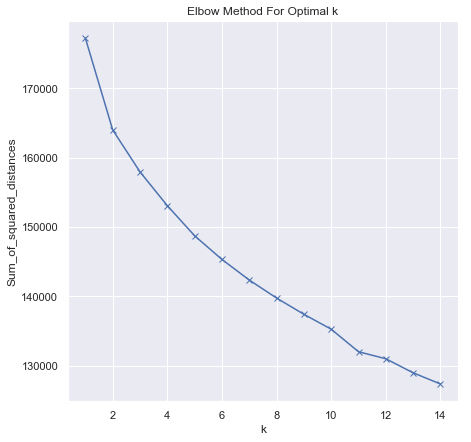

In [31]:
#compute the sum of squares for 32 clusters
plt.rcParams["figure.figsize"] = (7,7)
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    
    km = KMeans(n_clusters=k)
    km = km.fit(transform)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

plt.show()


This Plot about unconvincingly indicate that k=2 might be optimal clusters to look for in the data. The Silhouette method will be tried in the next segment to confirm this result.

In [32]:
for n_clusters in range(2,10):
   
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(transform)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(transform, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(transform, cluster_labels) 


For n_clusters = 2 The average silhouette_score is : 0.09491028796918567
For n_clusters = 3 The average silhouette_score is : 0.04396919063457125
For n_clusters = 4 The average silhouette_score is : 0.04072548716911979
For n_clusters = 5 The average silhouette_score is : 0.04114726698486824
For n_clusters = 6 The average silhouette_score is : 0.041611413032704
For n_clusters = 7 The average silhouette_score is : 0.043017718171927975
For n_clusters = 8 The average silhouette_score is : 0.04259395243971789
For n_clusters = 9 The average silhouette_score is : 0.04633739428314758


The Silhouette method confirmed the optimal K=2 to 2 found the previous method and also indicate that the identified clusters are weak because the best silhouette score obtain is less than 0.1

This is a suggestion for more data processing. Thus feature selection analysis will be carried out to obtain a new set of components based on the features with better clustering power.

### Principal Component Analysis
The goal of using pca will be to find the optimal of components and that adds the most value for the analysis.

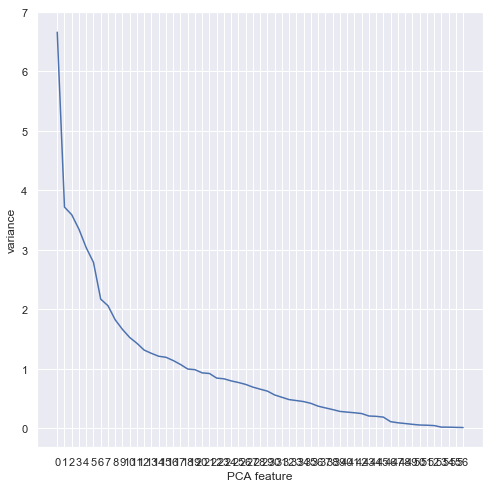

In [33]:
pca = PCA()
pca.fit(transform)
PCA(copy=True)

# Do the rest on your own :)
features = range(pca.n_components_)

plt.rcParams["figure.figsize"] = (8,8)
plt.plot(features, pca.explained_variance_)
#plt.axvline(x=3, c='red', linestyle = '-.')
#plt.axvline(x=6, c='purple', linestyle = '-.')

plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()

Text(0.5, 1.0, 'Cummulative Explained Variance')

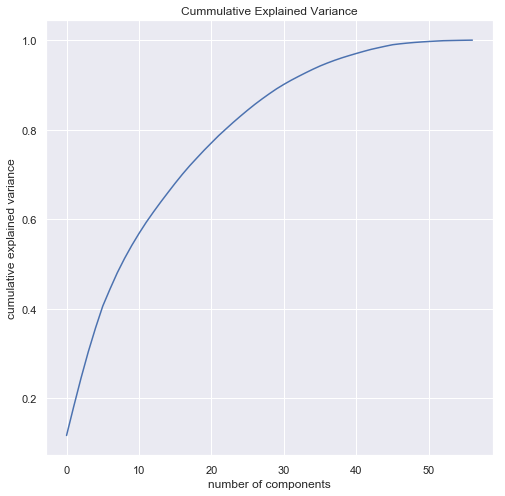

In [34]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Cummulative Explained Variance')

Based on the plot above, K-means will be implemented using PCA analysis with 40 components since almost 80% of the variance can be explained from the components

### K-Means based on new PCA components
Based on the cummulative explained variance of the pca components above, 40 of the components that explain 80% of the variance in the data will be used. The segment below will create a K-Mean for 2 - 10 clusters and evaluate each to identify the best model.

In [35]:
model = PCA(n_components=40)
model.fit(df1)

PCA(copy=True)

transformed = model.transform(df1)


features = model.n_components_
df_pca = pd.DataFrame(transformed, index=df1.index)

cols = []
for i in range(40):
    cols.append('pca_' + str(i))

    
df_pca.columns = cols

Sum_of_squared_distances = []
K = [2,3,4,5,6,7,8,9,10]

for i in K:
    c = 'cluster' + str(i) + 'labels'
    km = KMeans(n_clusters=i)
    km = km.fit(df_pca)
    df_pca[c] = km.predict(df_pca)
    #df_pca[c] = KMeans(n_clusters=i).fit_predict(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

For n_clusters = 2 The average silhouette_score is : 0.5711688068699794
For n_clusters = 3 The average silhouette_score is : 0.4932851542030041
For n_clusters = 4 The average silhouette_score is : 0.44279087764789465
For n_clusters = 5 The average silhouette_score is : 0.3965845862325596
For n_clusters = 6 The average silhouette_score is : 0.3790883522237666
For n_clusters = 7 The average silhouette_score is : 0.3395613776949917
For n_clusters = 8 The average silhouette_score is : 0.32630035291800424
For n_clusters = 9 The average silhouette_score is : 0.28823118554056343


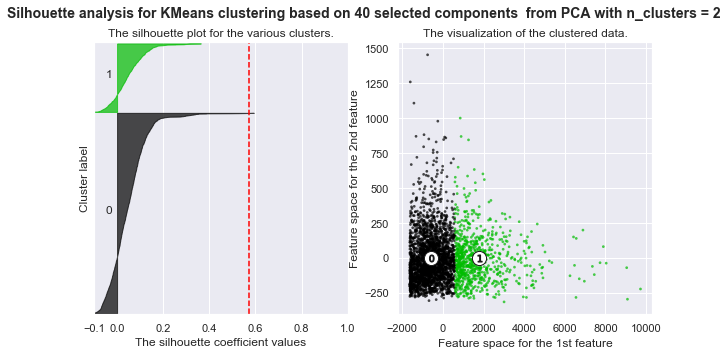

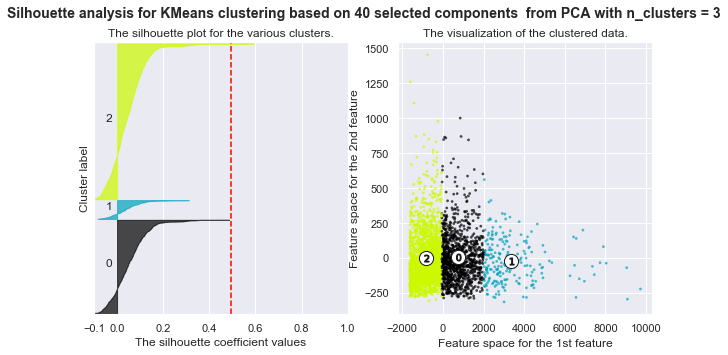

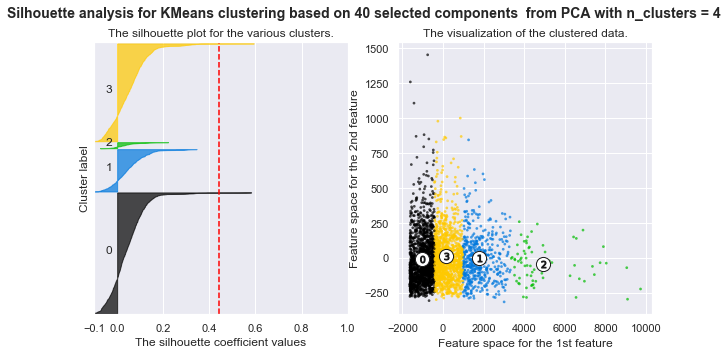

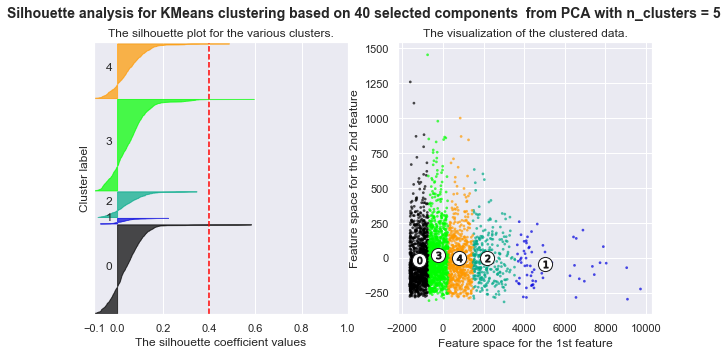

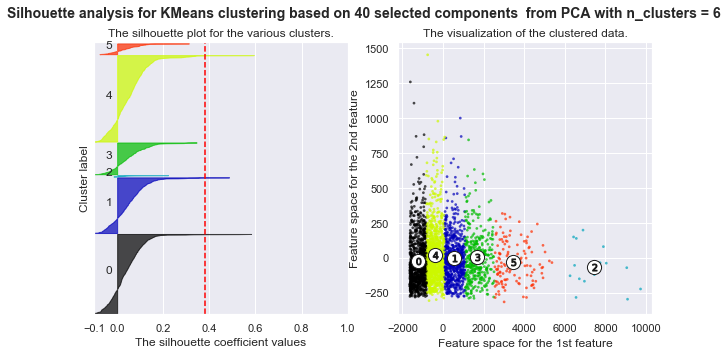

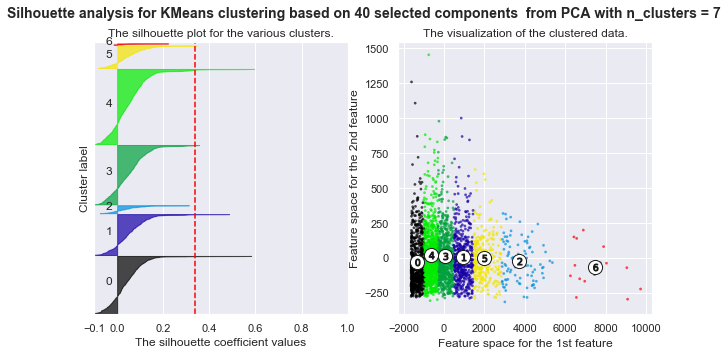

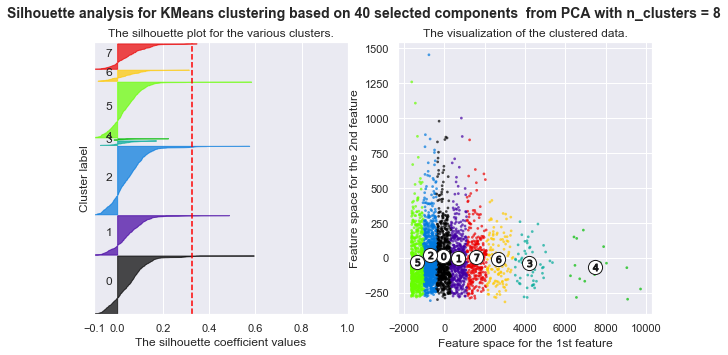

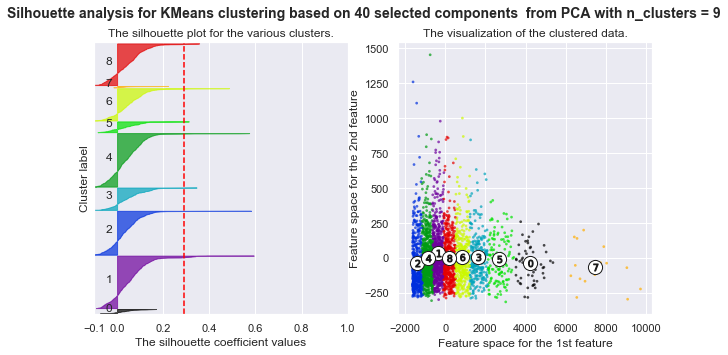

In [37]:
dd = pd.DataFrame(transformed)

for n_clusters in range(2,10):
   
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dd) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dd)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dd, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    # sample_silhouette_values = []
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dd.loc[:, 0], dd.loc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='K')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering based on 40 selected components  "
              "from PCA with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The analysis above show that there is a significant improvement in the result of the K-Means based on components identified from PCA. The best silhoutte scores is now 0.57, suggesting the identification of relatively heterogenious clusters at K=2. Therefore the rest of this notebook will be used to identify the characteristics of the 2 sub-groups identified in the sepsis population.

In [39]:
#Create a new dataset that combines the features, the clusters and labels
dfmain = df1.join(dfL)

dfmain1_ = dfmain.join(df_pca )

dfmain1 = dfmain1_.join(dfout)
#dfmain1.head()

### 2D view of the identified clusters
There are more than 40 dimensions obtained from PCA used in the KMeans analysis. THis will be difficult to visualize, but the 2 most important components below provides a 2D view of the clusters below.

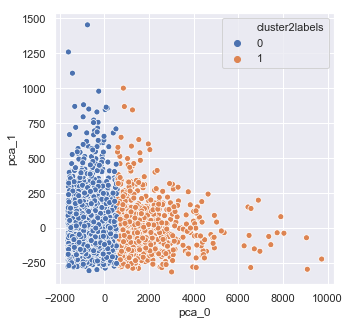

In [45]:
plt.rcParams["figure.figsize"] = (5,5)
sns.scatterplot(x=dfmain1.loc[:,'pca_0'], y=dfmain1.loc[:,'pca_1'], hue=dfmain1['cluster2labels'])

### Explore the effect of Clusters 

In order to identify the characteristics of the 2 clusters identified with K-Mean, the following areas was explored 
+ Patient Outcomes
+ Vital Signs
+ Laboratory

Each data point was explored visually, thereafter, relevant statistical test of significance was carried out.


### Patient Outcomes

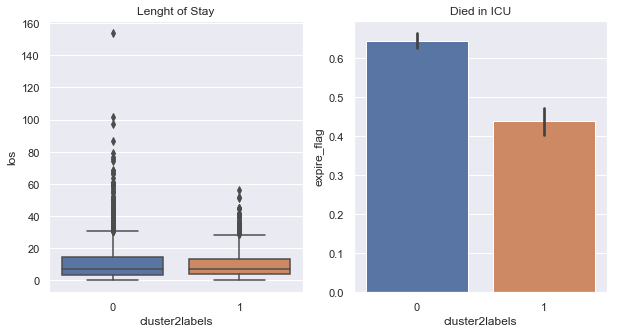

In [60]:
plt.rcParams["figure.figsize"] = (10,5)
fig, (ax1, ax2) = plt.subplots(ncols=2)

sns.boxplot(x="cluster2labels", y="los",  data=dfmain1, ax=ax1)
sns.barplot(x="cluster2labels", y="expire_flag",  data=dfmain1, ax=ax2)

ax1.set_title('Lenght of Stay')
ax2.set_title('Died in ICU')

plt.show()

In [102]:
grps = pd.unique(dfmain1.cluster2labels.values)
d_data = {grp:dfmain1['los'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('los:  ' + str(p))


d_data = {grp:dfmain1['expire_flag'][dfmain1.cluster2labels == grp] for grp in grps}
count = np.array([len(d_data[0][d_data[0] == 1]), len(d_data[1][d_data[1] == 1])])
nobs = np.array([len(d_data[0]), len(d_data[1])])
stat, pval = proportions_ztest(count, nobs)

print('expire_flag:  ' + str(pval))

los:  Ttest_indResult(statistic=1.4797073095385587, pvalue=0.13914293383157714)
expire_flag:  1.6644035308794914e-24


The results above show that there is not significant difference in the lenght of stay at ICU, however the probability of mortality in ICU is higher in cluster 1. 

### Vital Signs

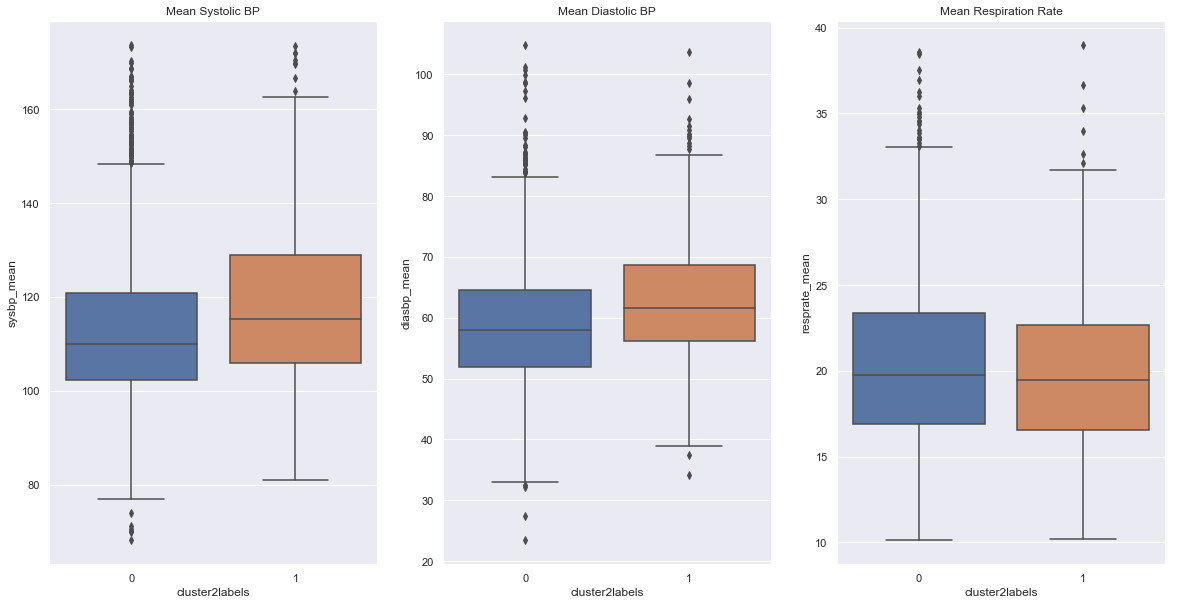

In [157]:
plt.rcParams["figure.figsize"] = (20,10)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)


sns.boxplot(x="cluster2labels", y="sysbp_mean",  data=dfmain1, ax=ax1)
sns.boxplot(x="cluster2labels", y="diasbp_mean",  data=dfmain1, ax=ax2)
sns.boxplot(x="cluster2labels", y="resprate_mean",  data=dfmain1, ax=ax3)

ax1.set_title('Mean Systolic BP')
ax2.set_title('Mean Diastolic BP')
ax3.set_title('Mean Respiration Rate')

plt.show()

In [159]:
grps = pd.unique(dfmain1.cluster2labels.values)

d_data = {grp:dfmain1['sysbp_mean'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('sysbp_mean:  ' + str(p))

d_data = {grp:dfmain1['diasbp_mean'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('diasbp_mean:  ' + str(p))

d_data = {grp:dfmain1['resprate_mean'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('resprate_mean:  ' + str(p))

sysbp_mean:  Ttest_indResult(statistic=-8.555183882774125, pvalue=3.2756258203272576e-17)
diasbp_mean:  Ttest_indResult(statistic=-9.86330458617925, pvalue=3.283363168234177e-22)
resprate_mean:  Ttest_indResult(statistic=2.760355098362977, pvalue=0.005847122878342816)


There is also signifcant difficence in the blood pressure and mean respiration rate in Cluster 0 1nd 1. Although this is difference appears to be marginal from the plots.

## Laboratory Values

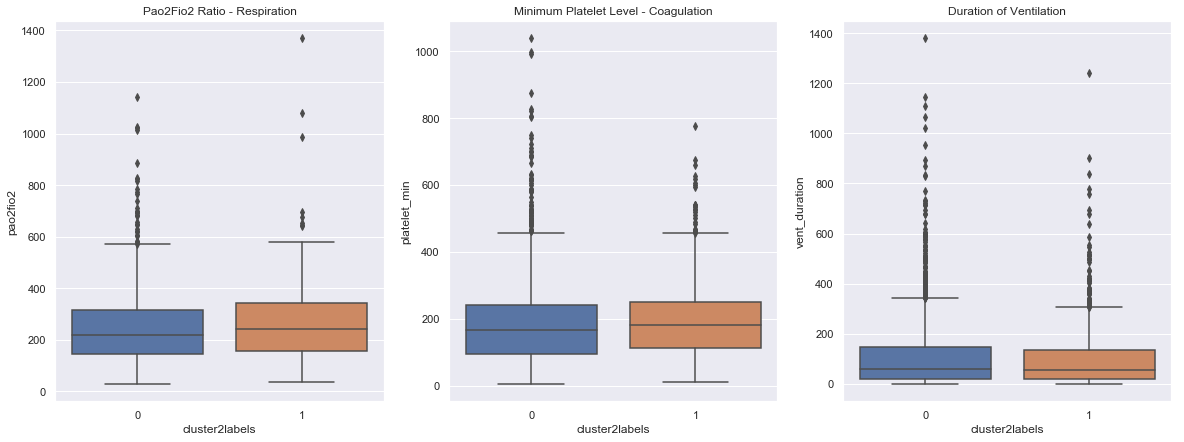

In [125]:
plt.rcParams["figure.figsize"] = (20,7)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

sns.boxplot(x="cluster2labels", y="pao2fio2",  data=dfmain1, ax=ax1)
sns.boxplot(x="cluster2labels", y="platelet_min",  data=dfmain1, ax=ax2)
sns.boxplot(x="cluster2labels", y="vent_duration",  data=dfmain1, ax=ax3)

ax1.set_title('Pao2Fio2 Ratio - Respiration')
ax2.set_title('Minimum Platelet Level - Coagulation')
ax3.set_title('Duration of Ventilation')
plt.show()

In [120]:

grps = pd.unique(dfmain1.cluster2labels.values)
d_data = {grp:dfmain1['pao2fio2'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('pao2fio2:  ' + str(p))

d_data = {grp:dfmain1['platelet_min'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('platelet_min:  ' + str(p))

d_data = {grp:dfmain1['vent_duration'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('vent_duration:  ' + str(p))


pao2fio2:  Ttest_indResult(statistic=-3.301290738559355, pvalue=0.0009884992714025316)
platelet_min:  Ttest_indResult(statistic=-1.7342010279722295, pvalue=0.08309402881725002)
vent_duration:  Ttest_indResult(statistic=1.1843443399157112, pvalue=0.23647972190920805)


The duration of mechanical ventilation and platelet level from the blood in both clusters is not different, however it is interesting to note that there is a significant difference in the PaO2/FiO2 ratio. This is because this ratio is a one of the critical variables used in defining sepsis3.

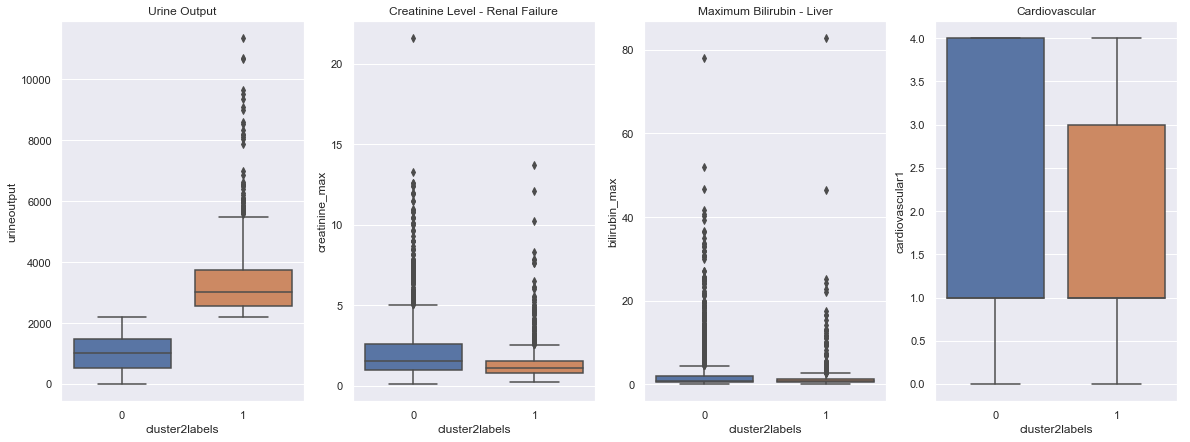

In [155]:
plt.rcParams["figure.figsize"] = (20,7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)

sns.boxplot(x="cluster2labels", y="urineoutput",  data=dfmain1, ax=ax1)
sns.boxplot(x="cluster2labels", y="creatinine_max",  data=dfmain1, ax=ax2)
sns.boxplot(x="cluster2labels", y="bilirubin_max",  data=dfmain1, ax=ax3)
sns.boxplot(x="cluster2labels", y="cardiovascular1",  data=dfmain1, ax=ax4)

ax1.set_title('Urine Output')
ax2.set_title('Creatinine Level - Renal Failure')
ax3.set_title('Maximum Bilirubin - Liver')
ax4.set_title('Cardiovascular')
plt.show()

In [154]:
grps = pd.unique(dfmain1.cluster2labels.values)
d_data = {grp:dfmain1['urineoutput'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('urineoutput:  ' + str(p))

d_data = {grp:dfmain1['creatinine_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('creatinine_max - Renal:  ' + str(p))

d_data = {grp:dfmain1['bilirubin_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('bilirubin_max:  ' + str(p))

d_data = {grp:dfmain1['cardiovascular1'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('cardiovascular1:  ' + str(p))


urineoutput:  Ttest_indResult(statistic=-50.7577070142829, pvalue=1.7770508185615877e-268)
creatinine_max - Renal:  Ttest_indResult(statistic=10.919488631832353, pvalue=5.7060491375292525e-27)
bilirubin_max:  Ttest_indResult(statistic=4.530147428296443, pvalue=6.323956669990423e-06)
cardiovascular1:  Ttest_indResult(statistic=8.316005734190544, pvalue=2.070437987296694e-16)


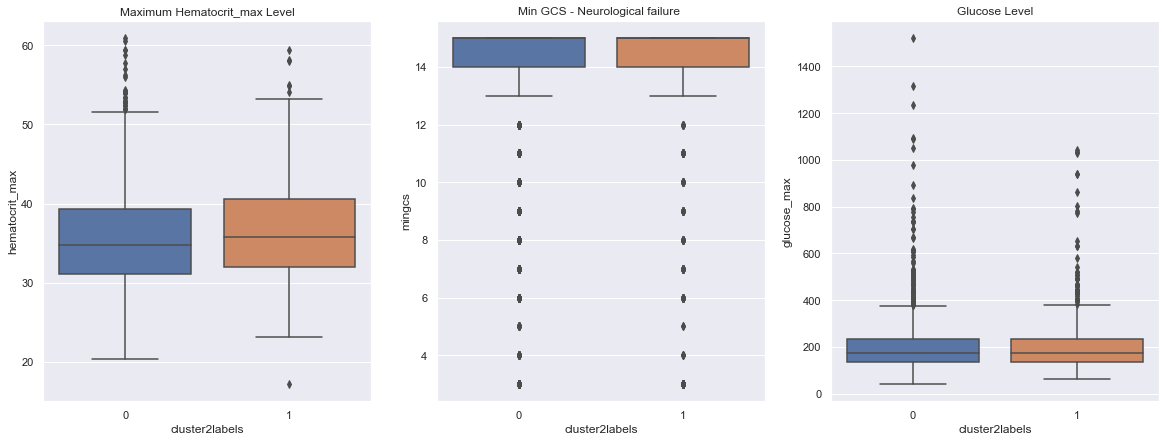

In [138]:
#creatinine_min', 'creatinine_max', 'chloride_min'
plt.rcParams["figure.figsize"] = (20,7)
fig, (ax1, ax2, ax3,) = plt.subplots(ncols=3)

sns.boxplot(x="cluster2labels", y="hematocrit_max",  data=dfmain1, ax=ax1)
sns.boxplot(x="cluster2labels", y="mingcs",  data=dfmain1, ax=ax2)
sns.boxplot(x="cluster2labels", y="glucose_max",  data=dfmain1, ax=ax3)


ax1.set_title('Maximum Hematocrit_max Level')
ax2.set_title('Min GCS - Neurological failure ')
ax3.set_title('Glucose Level')
plt.show()

In [139]:
grps = pd.unique(dfmain1.cluster2labels.values)
d_data = {grp:dfmain1['hematocrit_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('hematocrit_max:  ' + str(p))

d_data = {grp:dfmain1['mingcs'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('mingcs:  ' + str(p))

d_data = {grp:dfmain1['glucose_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('glucose_max:  ' + str(p))

hematocrit_max:  Ttest_indResult(statistic=-3.201709078963445, pvalue=0.0013981605070316804)
mingcs:  Ttest_indResult(statistic=-1.4900551512431852, pvalue=0.13642667637650502)
glucose_max:  Ttest_indResult(statistic=-0.4393457389717976, pvalue=0.6604850859208684)


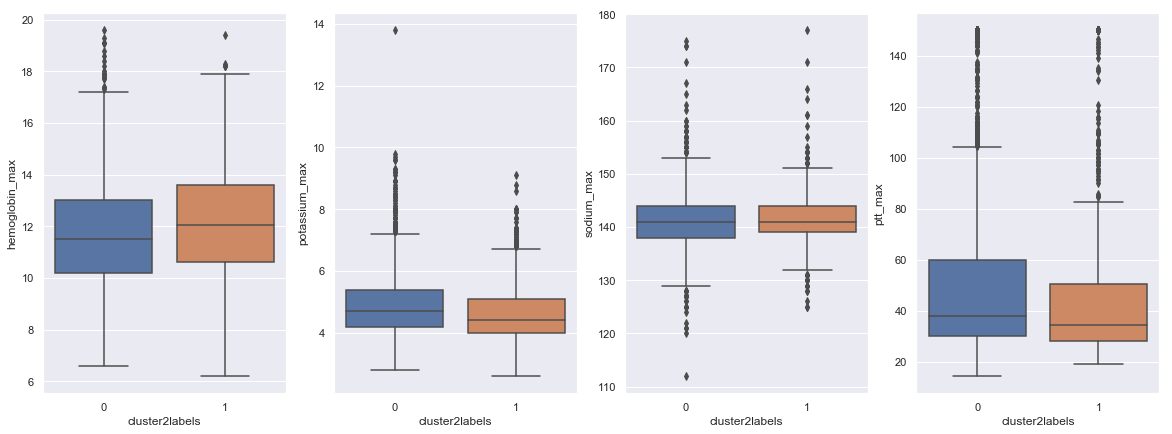

In [145]:
plt.rcParams["figure.figsize"] = (20,7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4)

sns.boxplot(x="cluster2labels", y="hemoglobin_max",  data=dfmain1, ax=ax1)
sns.boxplot(x="cluster2labels", y="potassium_max",  data=dfmain1, ax=ax2)
sns.boxplot(x="cluster2labels", y="sodium_max",  data=dfmain1, ax=ax3)
sns.boxplot(x="cluster2labels", y="ptt_max",  data=dfmain1, ax=ax4)
plt.show()

In [146]:
grps = pd.unique(dfmain1.cluster2labels.values)

d_data = {grp:dfmain1['hemoglobin_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('hemoglobin_max:  ' + str(p))

d_data = {grp:dfmain1['potassium_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('potassium_max:  ' + str(p))

d_data = {grp:dfmain1['sodium_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('sodium_max:  ' + str(p))

d_data = {grp:dfmain1['ptt_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('ptt_max:  ' + str(p))

hemoglobin_max:  Ttest_indResult(statistic=-4.5396043891591695, pvalue=6.1428821781037645e-06)
potassium_max:  Ttest_indResult(statistic=5.76852392205214, pvalue=9.752210304667892e-09)
sodium_max:  Ttest_indResult(statistic=-3.0648430304043854, pvalue=0.002218563176361777)
ptt_max:  Ttest_indResult(statistic=3.1394658491925536, pvalue=0.0017282037881129748)


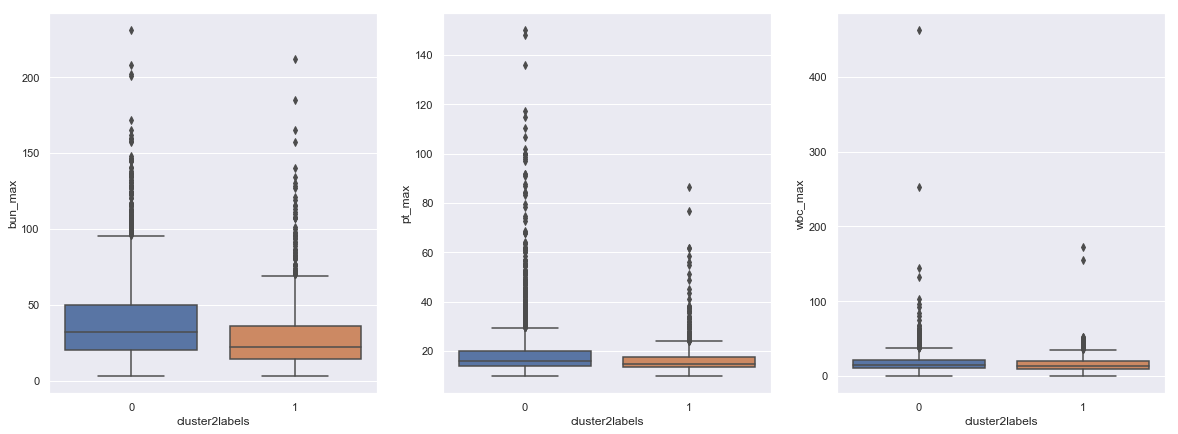

In [148]:
plt.rcParams["figure.figsize"] = (20,7)
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

sns.boxplot(x="cluster2labels", y="bun_max",  data=dfmain1, ax=ax1)
sns.boxplot(x="cluster2labels", y="pt_max",  data=dfmain1, ax=ax2)
sns.boxplot(x="cluster2labels", y="wbc_max",  data=dfmain1, ax=ax3)
plt.show()

In [149]:
grps = pd.unique(dfmain1.cluster2labels.values)
d_data = {grp:dfmain1['bun_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('bun_max:  ' + str(p))

d_data = {grp:dfmain1['wbc_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('wbc_max:  ' + str(p))

d_data = {grp:dfmain1['pt_max'][dfmain1.cluster2labels == grp] for grp in grps}
p = stats.ttest_ind(d_data[0], d_data[1], equal_var = False)
print('pt_max:  ' + str(p))

bun_max:  Ttest_indResult(statistic=9.044225255918086, pvalue=4.638359501386812e-19)
wbc_max:  Ttest_indResult(statistic=2.487366191479305, pvalue=0.012958135742893822)
pt_max:  Ttest_indResult(statistic=7.866865175741748, pvalue=5.435079670375334e-15)


In [166]:
f_sig =['expire_flag', 'pao2fio2', 'urineoutput', 'sysbp_mean','diasbp_mean','resprate_mean',
        'bilirubin_max','creatinine_max','cardiovascular1',  'hematocrit_max', 'hemoglobin_max',
        'potassium_max','sodium_max', 'ptt_max',
        'bun_max', 'pt_max', 'wbc_max','cluster2labels']

In [245]:
mean_ = dfmain1[f_sig].groupby(['cluster2labels']).mean().T
mean_.columns = ['mean_0', 'mean_1']

std_ = dfmain1[f_sig].groupby(['cluster2labels']).std().T
std_.columns = ['std_0', 'std_1']

al =mean_.join(std_)
al

,mean_0,mean_1,std_0,std_1
expire_flag,0.644799,0.438131,0.478677,0.496471
pao2fio2,240.968561,259.143697,127.753347,135.745292
urineoutput,1017.061286,3392.967172,603.859452,1269.124300
sysbp_mean,112.737781,118.500551,15.559639,16.631410
diasbp_mean,58.751909,62.784244,9.853004,9.959248
resprate_mean,20.358913,19.856915,4.602901,4.353358
bilirubin_max,2.487743,1.657197,5.067397,4.224185
creatinine_max,2.083384,1.443182,1.787892,1.276622
cardiovascular1,2.255503,1.763889,1.505135,1.411909
hematocrit_max,35.567760,36.388889,6.125093,6.266541


The table above are the variables where significant differences were noticed between the 2 identified clusters. Based on the table above, it seems the number of organ failure and severity of damage clearly separates the sepsis population into 2. Against the Sepsis 3 definition, this result suggest that severe sepsis might exist and further research may be required to tailor treatment protocols to the 2 identified categories.

References:

Multidimensional Visualizations - https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57

Feature Selection - https://machinelearningmastery.com/feature-selection-machine-learning-python/

Curse of Dimentionality - https://stats.stackexchange.com/questions/99171/why-is-euclidean-distance-not-a-good-metric-in-high-dimensions/

ON the suprising behavior of distance metrics in high dimensional space - http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.23.7409&rep=rep1&type=pdf

In Depth: Principal Component Analysis: https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html